`对于建立意在预测而非解释的模型，有两个要点：`
- 以上列出的对绕封方法的批评针对的是统计假设检验的使用
- 如本书中我们讨论的其它许多例子，基于有争论的统计原则的方法依旧可能给出非常准确的模型。关键在于我们需要建立缜密的，系统的模型评估的过程，该过程基于的数据要和建模使用的数据独立。

In [1]:
library(AppliedPredictiveModeling)
data(AlzheimerDisease)
ls()

[1] "diagnosis"  "predictors"

In [7]:
str(predictors)

'data.frame':	333 obs. of  130 variables:
 $ ACE_CD143_Angiotensin_Converti  : num  2 1.56 1.52 1.68 2.4 ...
 $ ACTH_Adrenocorticotropic_Hormon : num  -1.386 -1.386 -1.715 -1.609 -0.968 ...
 $ AXL                             : num  1.098 0.683 -0.145 0.683 0.191 ...
 $ Adiponectin                     : num  -5.36 -5.02 -5.81 -5.12 -4.78 ...
 $ Alpha_1_Antichymotrypsin        : num  1.74 1.46 1.19 1.28 2.13 ...
 $ Alpha_1_Antitrypsin             : num  -12.6 -11.9 -13.6 -15.5 -11.1 ...
 $ Alpha_1_Microglobulin           : num  -2.58 -3.24 -2.88 -3.17 -2.34 ...
 $ Alpha_2_Macroglobulin           : num  -72.7 -154.6 -136.5 -98.4 -144.9 ...
 $ Angiopoietin_2_ANG_2            : num  1.065 0.742 0.833 0.916 0.956 ...
 $ Angiotensinogen                 : num  2.51 2.46 1.98 2.38 2.86 ...
 $ Apolipoprotein_A_IV             : num  -1.43 -1.66 -1.66 -2.12 -1.17 ...
 $ Apolipoprotein_A1               : num  -7.4 -7.05 -7.68 -8.05 -6.73 ...
 $ Apolipoprotein_A2               : num  -0.2614 -0.8675

In [6]:
col_baseline <- c("Genotype", "age", "tau", "p_tau", "Ab_42", "male")
col_newassays <- colnames(predictors)
col_newassays <- col_newassays[!(col_newassays %in% c("Class",col_baseline))]

In [9]:
summary(predictors$Genotype)
predictors$E2 <- predictors$E3 <- predictors$E4 <- 0
predictors$E2[grepl("2",predictors$Genotype)] <- 1
predictors$E3[grepl("3",predictors$Genotype)] <- 1
predictors$E4[grepl("4",predictors$Genotype)] <- 1
genotype <- predictors$Genotype

E2E2 E2E3 E2E4 E3E3 E3E4 E4E4 
   2   37    8  167  106   13

In [17]:
library(caret)
set.seed(730)
trn_id <- createDataPartition(diagnosis,p=0.8,list=F)
df_all <- predictors
df_all$Class <- diagnosis

trn <- df_all[trn_id,]
vld <- df_all[-trn_id,]

col_pred <- names(subset(predictors, select = -Genotype))

In [18]:
fiveStats <- function(...) c(twoClassSummary(...),defaultSummary(...))

In [19]:
set.seed(104)
index <- createMultiFolds(trn$Class,times=5)

In [22]:
## The candidate set of the number of predictors to evaluate
varSeq <- seq(1,length(col_pred)-1,by=2)

In [24]:
library(doMC)
registerDoMC()

In [25]:
ctrl <- rfeControl(method="repeatedcv",repeats=5,
                  saveDetails=T,index=index,returnResamp="final")

fullCtrl <- trainControl(method = "repeatedcv",repeats=5,
                        summaryFunction=fiveStats,classProbs=T,index=index)

corrplot 0.84 loaded


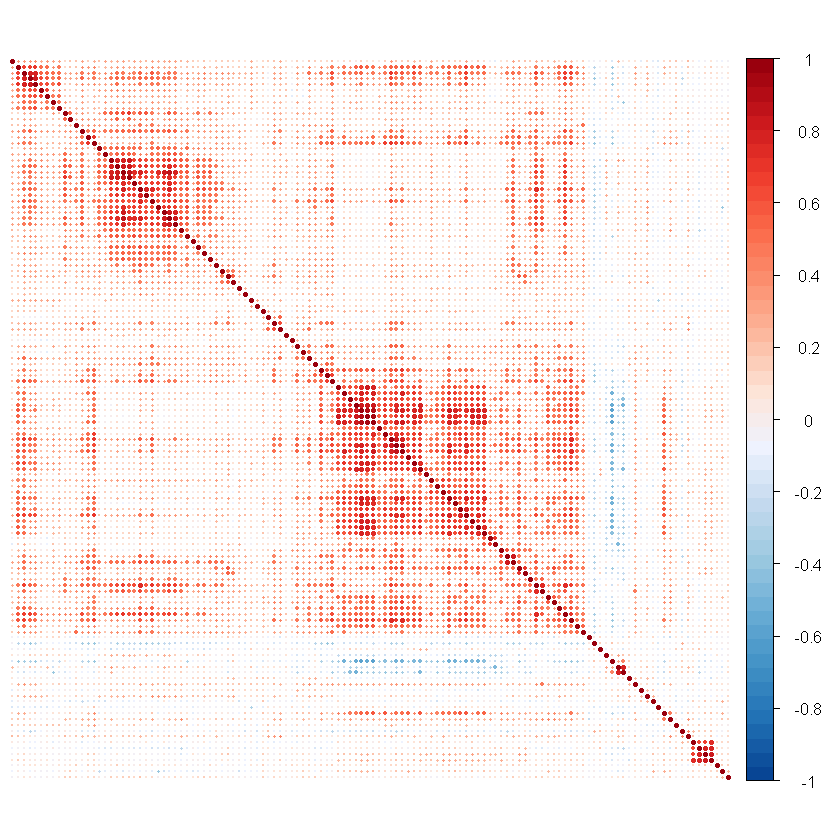

In [26]:
cor_info <- cor(trn[,col_newassays])

library(RColorBrewer)
cols <- c(rev(brewer.pal(7,"Blues")),
         brewer.pal(7,"Reds"))

library(corrplot)
corrplot(cor_info,order="hclust",tl.pos="n",addgrid.col=rgb(1,1,1,0.01),
        col=colorRampPalette(cols)(51))

&#x1F52E; `Fit a series of models w/ full set`

In [28]:
set.seed(721)
fit_rf_full <- train(trn[,col_pred],trn$Class,method="rf",
                     metric="ROC",tuneGrid=data.frame(mtry=floor(sqrt(length(col_pred)))),
                    ntree=1000,trControl=fullCtrl)
fit_rf_full

Random Forest 

267 samples
132 predictors
  2 classes: 'Impaired', 'Control' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa    
  0.8918191  0.4410714  0.9815263  0.8337057  0.4921873

Tuning parameter 'mtry' was held constant at a value of 11

In [29]:
set.seed(721)
fit_lda_full <- train(trn[,col_pred],trn$Class,
                     method="lda",metric="ROC",tol=1.0e-12,trControl=fullCtrl)
fit_lda_full

Linear Discriminant Analysis 

267 samples
132 predictors
  2 classes: 'Impaired', 'Control' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results:

  ROC       Sens       Spec       Accuracy   Kappa    
  0.842438  0.6857143  0.8294211  0.7899735  0.4909981


In [30]:
set.seed(721)
fit_svm_full <- train(trn[,col_pred],trn$Class,
                     method="svmRadial",metric="ROC",tuneLength=12,
                     preProc=c("center","scale"),trControl=fullCtrl)
fit_svm_full

Support Vector Machines with Radial Basis Function Kernel 

267 samples
132 predictors
  2 classes: 'Impaired', 'Control' 

Pre-processing: centered (132), scaled (132) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  C       ROC        Sens       Spec       Accuracy   Kappa    
    0.25  0.8793383  0.7282143  0.8992105  0.8519678  0.6275865
    0.50  0.8793383  0.7328571  0.8981579  0.8526557  0.6299489
    1.00  0.8846664  0.7025000  0.9260000  0.8647110  0.6474002
    2.00  0.8921429  0.6967857  0.9362105  0.8704721  0.6558131
    4.00  0.8877021  0.6789286  0.9311579  0.8622629  0.6344336
    8.00  0.8799060  0.6582143  0.9208947  0.8489805  0.6013189
   16.00  0.8805808  0.6521429  0.9240526  0.8496113  0.6007579
   32.00  0.8805808  0.6492857  0.9261579  0.8503521  0.6016829
   64.00  0.8805808  0.6496429  0.9229474  0.8481278  0.5968627
  128.00  0.8805808  0.6492

`Numerical 0 probability for all classes with observation 1`

In [31]:
set.seed(721)
fit_nb_full <- train(trn[,col_pred],trn$Class,
                    method="nb",metric="ROC",trControl=fullCtrl)
fit_nb_full

Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]]

"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability

"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabil

"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability f

"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for 

"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability fo

"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability

"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabili

"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabili

"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabilit

"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability fo

"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability f

"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabilit

"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabili

"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability 

"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for

"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability f

"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability

"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabilit

"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability fo

"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability f

"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabil

"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability f

"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for 

"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability fo

"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability

"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabilit

"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for 

"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability 

"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabili

"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 27"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabilit

"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability fo

"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability f

"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabilit

"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabili

"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabil

"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabil

"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability fo

"Numerical 0 probability for all classes with observation 28"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for 

"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for

"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabili

"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabi

"Numerical 0 probability for all classes with observation 18"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 19"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 20"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 21"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 22"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 23"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabil

"Numerical 0 probability for all classes with observation 24"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 25"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 26"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 1"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 2"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 3"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability fo

"Numerical 0 probability for all classes with observation 4"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 5"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 6"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability f

"Numerical 0 probability for all classes with observation 7"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabilit

"Numerical 0 probability for all classes with observation 8"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 9"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 10"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 11"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 12"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 13"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 14"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 15"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 16"Warning message in FUN(X[[i]], ...):
"Numerical 0 probability for all classes with observation 17"Warning message in FUN(X[[i]], ...):
"Numerical 0 probabili

Naive Bayes 

267 samples
132 predictors
  2 classes: 'Impaired', 'Control' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  usekernel  ROC        Sens       Spec       Accuracy   Kappa    
  FALSE      0.7800301  0.6439286  0.7797895  0.7423260  0.3945587
   TRUE      0.7980028  0.5935714  0.8138947  0.7530037  0.3965766

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'adjust' was held constant at a value of 1
ROC was used to select the optimal model using the largest value.
The final values used for the model were fL = 0, usekernel = TRUE and adjust
 = 1.

In [32]:
set.seed(721)
fit_lr_full <- train(trn[,col_pred],trn$Class,
                    method="glm",metric="ROC",trControl=fullCtrl)
fit_lr_full

Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"Warning message:
"glm.fit: algorithm did not converge"Warning message:
"glm.fit: fitted pr

Generalized Linear Model 

267 samples
132 predictors
  2 classes: 'Impaired', 'Control' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa    
  0.7832115  0.6696429  0.7778947  0.7478022  0.4169576


In [33]:
set.seed(721)
fit_knn_full <- train(trn[,col_pred],trn$Class,
                     method="knn",metric="ROC",tuneLength=20,
                     preProc=c("center","scale"),trControl=fullCtrl)
fit_knn_full

k-Nearest Neighbors 

267 samples
132 predictors
  2 classes: 'Impaired', 'Control' 

Pre-processing: centered (132), scaled (132) 
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 241, 241, 241, 240, 240, 240, ... 
Resampling results across tuning parameters:

  k   ROC        Sens        Spec       Accuracy   Kappa     
   5  0.7782528  0.47607143  0.9278947  0.8041331  0.44383517
   7  0.7788200  0.45535714  0.9404737  0.8073525  0.44529229
   9  0.7934309  0.39142857  0.9629474  0.8064245  0.41435555
  11  0.8023637  0.37214286  0.9731579  0.8085877  0.41167325
  13  0.8102265  0.33571429  0.9670000  0.7942287  0.36197789
  15  0.8165381  0.32750000  0.9671053  0.7920879  0.35329461
  17  0.8208571  0.29750000  0.9794211  0.7928612  0.33791496
  19  0.8369497  0.28178571  0.9856842  0.7928592  0.32809108
  21  0.8470540  0.26500000  0.9845789  0.7875275  0.30692406
  23  0.8461400  0.24571429  0.9846316  0.7821693  0.29073729
  25  0.8429586  0.2317

In [ ]:
##   http://caret.r-forge.r-project.org/featureSelection.html
ctrl$functions <- rfFuncs
ctrl$functions$summary <- fiveStats

set.seed(721)
fit_rf_rfe <- rfe(trn[,col_pred],trn$Class,
                  sizes = varSeq,metric = "ROC",ntree=1000,rfeControl = ctrl)
fit_rf_rfe

In [ ]:
ctrl$functions <- ldaFuncs
ctrl$functions$summary <- fiveStats

set.seed(721)
fit_lda_rfe <- rfe(trn[,col_pred],trn$Class,
                   sizes=varSeq,metric="ROC",tol=1.0e-12,rfeControl=ctrl)
fit_lda_rfe